In [1]:
import jax
import jax.numpy as jnp
from evosax import ParameterReshaper
import ipyplot
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


# Setup

### Create environment

In [2]:
import gymnax as gym

/Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [3]:
env_name = "Reacher-misc"
env, env_params = gym.make(env_name)
n_actions = env.action_space(env_params).shape[0]
obs_dims = env.observation_space(env_params).shape[0]

In [4]:
env_steps = env_params.max_steps_in_episode

### Create NDP and Policy

In [5]:
from models import HyperNCA, HyperNCA_Config
from policies import MLPPolicy

In [6]:
# MLP configuration
mlp_hidden_dims = 12 # nb of features for each hidden layer
mlp_hidden_layers = 1 # nb of hidden layers
mlp_action_dims = n_actions 
mlp_obs_dims = obs_dims

In [7]:
policy = MLPPolicy(mlp_action_dims, mlp_hidden_layers,
                  mlp_hidden_dims, mode="continuous")
key = jax.random.PRNGKey(42)
policy_params = policy.init(key, jnp.zeros((obs_dims,)), key)
#policy_params

In [8]:
# NCA Configuration
channels = 4
alpha = 0.1 # alive threshold
perception_dims = 3 # nb of perception kernels
update_features = (16,) # hidden features of update network

iterations = 20 #number of development steps

In [9]:
ndp_config = HyperNCA_Config(
    channels = channels,
    alpha = alpha,
    perception_dims = perception_dims,
    update_features = update_features,
    iterations = iterations,
    action_dims = n_actions,
    obs_dims = obs_dims,
    hidden_dims = mlp_hidden_dims,
    hidden_layers = mlp_hidden_layers
)

In [10]:
ndp = HyperNCA(ndp_config)

In [11]:
z_dims = ndp.z_dims # nb of dimensions of the latent space (nb of channels for HyperNCA)
z_dims

4

In [12]:
ndp_params = ndp.init(jax.random.PRNGKey(42), jnp.ones((z_dims, )))
parameter_reshaper = ParameterReshaper(ndp_params)

ParameterReshaper: 580 parameters detected for optimization.


### Create evaluator

In [13]:
from evaluators import SimpleEvaluator, SimpleEvaluator_Config 
from envs import bd_extractors

In [14]:
evaluator_config = SimpleEvaluator_Config(
    epochs = 50,
    env = env,
    env_backend = "gymnax",
    env_params = env_params,
    env_steps = 500,
    n_params = z_dims,
    popsize = 16
)

In [15]:
evaluator = SimpleEvaluator(evaluator_config, ndp, policy)

### Create Trainer

In [16]:
from metandp import NDP_Trainer, Config

In [17]:
trainer_config = Config(
    epochs = 50,
    n_params = parameter_reshaper.total_params,
    params_shaper = parameter_reshaper,
    es = "openes",
    popsize = 32,
    es_config = {},
    es_params = None
)

In [18]:
ndp_trainer = NDP_Trainer(trainer_config, ndp, evaluator)

# Train

In [19]:
seed = 8501
key = jax.random.PRNGKey(seed)
es_state, data = ndp_trainer.train(key)

	inner gen 0 : max fit = 75.56510925292969
	inner gen 10 : max fit = 90.51815795898438
	inner gen 20 : max fit = 80.02139282226562


XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/jax/_src/interpreters/mlir.py(1760): _wrapped_callback
  /Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/jax/_src/interpreters/pxla.py(1346): __call__
  /Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/jax/_src/profiler.py(314): wrapper
  /Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/jax/_src/dispatch.py(142): apply_primitive
  /Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/jax/_src/core.py(790): process_primitive
  /Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/jax/_src/core.py(383): bind_with_trace
  /Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/jax/_src/core.py(2633): bind
  /Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/jax/_src/lax/control_flow/loops.py(1031): scan_bind
  /Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/jax/_src/lax/control_flow/loops.py(262): scan
  /Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/jax/_src/traceback_util.py(166): reraise_with_filtered_traceback
  /Users/erpl/Library/CloudStorage/OneDrive-ITU/Documents/projects/MetaNDP/metandp.py(115): train
  /var/folders/8d/5vjv51g957zb9g2039y64g1c0000gn/T/ipykernel_21433/3540490043.py(3): <module>
  /Users/erpl/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3508): run_code
  /Users/erpl/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3448): run_ast_nodes
  /Users/erpl/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3269): run_cell_async
  /Users/erpl/.local/lib/python3.11/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /Users/erpl/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3064): _run_cell
  /Users/erpl/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3009): run_cell
  /Users/erpl/.local/lib/python3.11/site-packages/ipykernel/zmqshell.py(540): run_cell
  /Users/erpl/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py(422): do_execute
  /Users/erpl/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py(729): execute_request
  /Users/erpl/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py(409): dispatch_shell
  /Users/erpl/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py(502): process_one
  /Users/erpl/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py(513): dispatch_queue
  /Users/erpl/anaconda3/envs/metandp/lib/python3.11/asyncio/events.py(80): _run
  /Users/erpl/anaconda3/envs/metandp/lib/python3.11/asyncio/base_events.py(1922): _run_once
  /Users/erpl/anaconda3/envs/metandp/lib/python3.11/asyncio/base_events.py(607): run_forever
  /Users/erpl/.local/lib/python3.11/site-packages/tornado/platform/asyncio.py(195): start
  /Users/erpl/.local/lib/python3.11/site-packages/ipykernel/kernelapp.py(725): start
  /Users/erpl/.local/lib/python3.11/site-packages/traitlets/config/application.py(1043): launch_instance
  /Users/erpl/.local/lib/python3.11/site-packages/ipykernel_launcher.py(17): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main


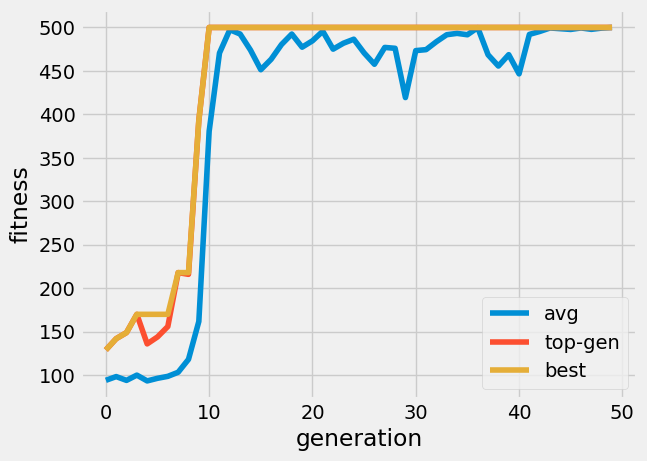

In [59]:
fitness = data['fitness']
avg_fitness = jnp.mean(fitness, axis=-1)
max_fitness = jnp.max(fitness, axis=-1)
best_fitness = -data['es_state'].best_fitness

plt.plot(avg_fitness, label='avg')
plt.plot(max_fitness, label='top-gen')
plt.plot(best_fitness, label='best')
plt.legend()
plt.xlabel('generation')
plt.ylabel('fitness')
plt.show()

In [60]:
inners = data["eval_data"]

In [61]:
inner_fits = inners["fitness"]
inner_fits.shape

(50, 64, 50, 16)

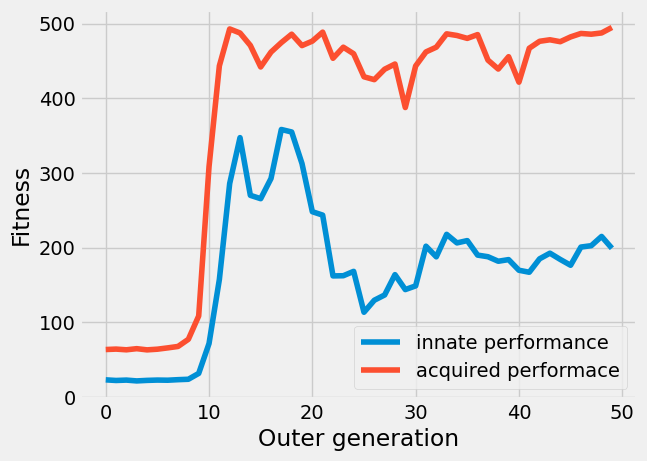

In [62]:
avg_start = jnp.mean(inner_fits[:, :, 0, :], axis=(1, 2))
avg_end = jnp.mean(jnp.max(inner_fits, axis=2), axis=(1, 2))
plt.plot(avg_start, label="innate performance")
plt.plot(avg_end, label="acquired performace")
plt.legend()
plt.xlabel("Outer generation")
plt.ylabel("Fitness")
plt.show()

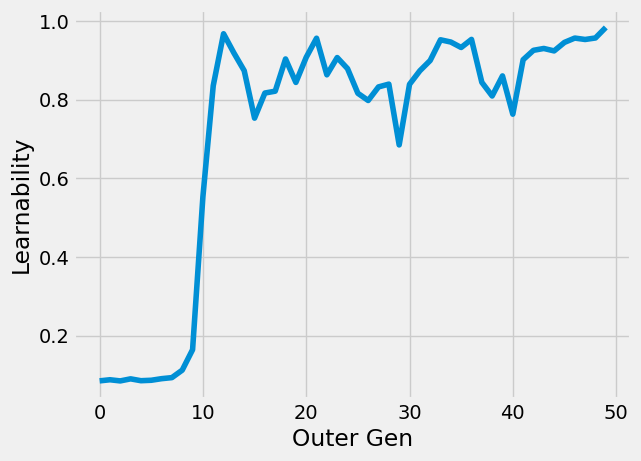

In [99]:
learnability = (avg_end - avg_start) / (500-avg_start+1e-8)
plt.plot(learnability)
plt.xlabel("Outer Gen")
plt.ylabel("Learnability")
plt.show()

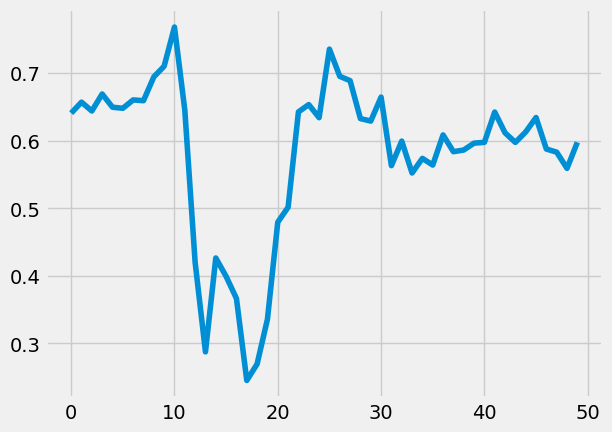

In [106]:
learn_reliance = (avg_end-avg_start)/avg_end
plt.plot(learn_reliance)
plt.show()

# Holistic Training

In [25]:
from evosax import OpenES

In [82]:
popsize = 64
es = OpenES(num_dims=parameter_reshaper.total_params+z_dims,
           popsize = popsize)
es_params = es.default_params

In [ ]:
test = jax.vmap(evaluator.eval)

In [84]:
def es_step(carry, iter):

    es_state, key = carry
    key, ask_key, eval_key = jax.random.split(key, 3)

    params, es_state = es.ask(ask_key, es_state, es_params) 
    z = params[:, :z_dims]
    ndp_params_fl = params[:, z_dims:]
    ndp_params = parameter_reshaper.reshape(ndp_params_fl)
    
    policy_params = jax.vmap(ndp.apply, in_axes=(0, 0))(ndp_params, z)

    eval_keys = jax.random.split(eval_key, popsize)
    rollout_data = jax.vmap(evaluator.env_rollout, in_axes=(0, 0))(eval_keys, policy_params)
    fitness = rollout_data["cum_rewards"]
    fitness_re = evaluator.es_fitness_shaper.apply(params, fitness)
    
    acq_fitness = test(ndp_params, eval_keys)

    es_state = es.tell(params, fitness_re, es_state, es_params)

    data = {
        'fitness': fitness, 
        'aca_fitness': acq_fitness,
        'es_state': es_state,
    }

    return [es_state, key], data

key = jax.random.PRNGKey(seed)
key, init_key = jax.random.split(key)
es_state = es.initialize(init_key, es_params)
gens = jnp.arange(50)
[es_state, _], data_test = jax.lax.scan(
    es_step,
    [es_state, key],
    gens
)

	inner gen 0 : max fit = 103.0
	inner gen 10 : max fit = 88.0
	inner gen 20 : max fit = 82.0
	inner gen 30 : max fit = 106.0
	inner gen 40 : max fit = 82.0
	inner gen 0 : max fit = 110.0
	inner gen 10 : max fit = 94.0
	inner gen 20 : max fit = 90.0
	inner gen 30 : max fit = 111.0
	inner gen 40 : max fit = 100.0
	inner gen 0 : max fit = 102.0
	inner gen 10 : max fit = 88.0
	inner gen 20 : max fit = 102.0
	inner gen 30 : max fit = 124.0
	inner gen 40 : max fit = 133.0
	inner gen 0 : max fit = 83.0
	inner gen 10 : max fit = 123.0
	inner gen 20 : max fit = 105.0
	inner gen 30 : max fit = 81.0
	inner gen 40 : max fit = 83.0
	inner gen 0 : max fit = 106.0
	inner gen 10 : max fit = 133.0
	inner gen 20 : max fit = 108.0
	inner gen 30 : max fit = 114.0
	inner gen 40 : max fit = 93.0
	inner gen 0 : max fit = 79.0
	inner gen 10 : max fit = 122.0
	inner gen 20 : max fit = 101.0
	inner gen 30 : max fit = 83.0
	inner gen 40 : max fit = 181.0
	inner gen 0 : max fit = 92.0
	inner gen 10 : max fit = 94

In [90]:
fitness_test = data_test["fitness"]
acq_fitness_test = data_test["aca_fitness"][0]
best = -data_test["es_state"].best_fitness

In [92]:
acq_fitness_test.shape, fitness_test.shape

((50, 64), (50, 64))

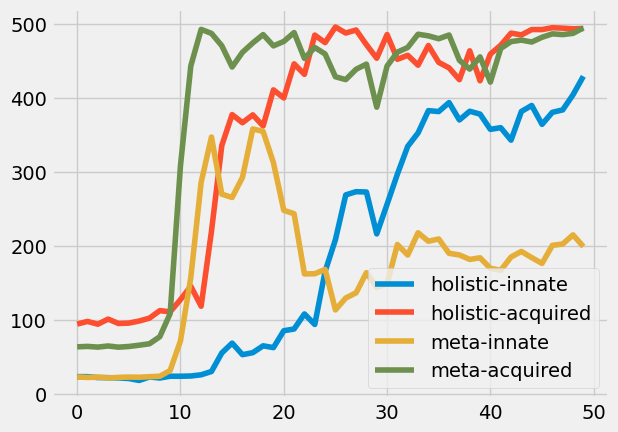

In [102]:
avg_start_test = jnp.mean(fitness_test, axis=-1)
avg_end_test = jnp.mean(acq_fitness_test, axis=-1)

plt.plot(avg_start_test, label="holistic-innate")
plt.plot(avg_end_test, label="holistic-acquired")

plt.plot(avg_start, label="meta-innate")
plt.plot(avg_end, label="meta-acquired")

plt.legend()
plt.show()

In [104]:
learnability_test = (avg_end_test - avg_start_test) /(500-avg_start_test+1e-8)

In [107]:
learn_reliance_test = (avg_end_test-avg_start_test)/avg_end_test

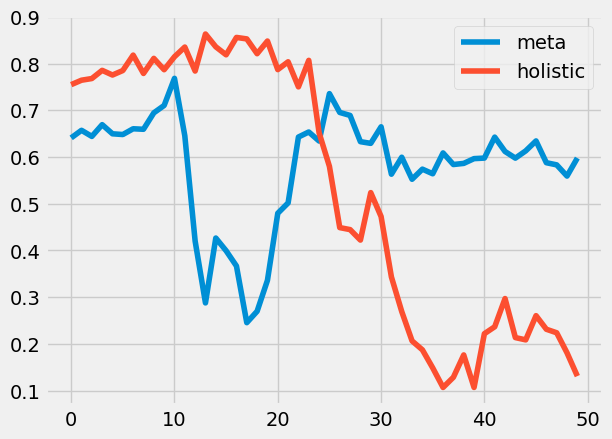

In [108]:
plt.plot(learn_reliance, label="meta")
plt.plot(learn_reliance_test, label="holistic")
plt.legend()
plt.show()